<a href="https://colab.research.google.com/github/liangchow/time-series-reservoir-water-level/blob/main/reservoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Up Worksheet and Import Libraries

In [1]:
# Clone Gitub repository to Colab
from google.colab import drive
drive.mount('/content/drive')

!apt-get install git
!git clone https://github.com/liangchow/time-series-reservoir-water-level.git

# Install auto arima
!pip install pmdarima

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'time-series-reservoir-water-level'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 91 (delta 49), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (91/91), 2.17 MiB | 5.27 MiB/s, done.
Resolving deltas: 100% (49/49), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.3 MB/s eta 0:00:00


In [2]:
# Import libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(8,3)}) # Set figure default size
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Read Well Data

In [3]:
# Read well data
file_path = "/content/time-series-reservoir-water-level/field_data/reservoir_data.csv"
dfs = pd.read_csv(file_path)
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        685 non-null    object 
 1   Water_Elev  685 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.8+ KB


In [4]:
# Drop a row of wrong format date: 10/??/2004
i = dfs[dfs["Date"] == "10/??/2004"].index
dfs.drop(labels=i, axis=0, inplace=True)

# Parse "Date" column
dfs['Date'] = pd.to_datetime(dfs['Date'])
dfs = dfs.sort_values(by="Date")

# Save data after 2019/6/27 as new df. Then drop them in the working dataset.
dfn = dfs[["Date", "Water_Elev"]][dfs["Date"] > "2019-06-27"]
i = dfs[dfs["Date"] > "2019-06-27"].index
dfs.drop(i, axis=0, inplace=True)
dfs.reset_index()

# Drop "NaT" rows
dfs.dropna(subset="Date", axis=0, inplace=True)

dfs.tail()

,Date,Water_Elev
665,2019-02-22,722.04
666,2019-03-29,722.31
667,2019-04-29,721.18
668,2019-05-23,720.17
669,2019-06-27,718.12


# Data Visualization and Resampling
Based on the `dfs.info()` above, the non-null values vary from 135 to 724, meaning that there are missing data all over the place. We will focus mainly on the water elevation. So below, we plot the originally observed data, then resample the dataset to weekly and monthly data. The data line is smoothened with monthly samples. Further below, the weekly-spaced dataset appears to have continuous missing values in the next few data points. This makes the weekly data less meaningful as we have to guess the missing values, e.g. 3 in a row, instead of averaging or interpolating between the previous and the next values.  

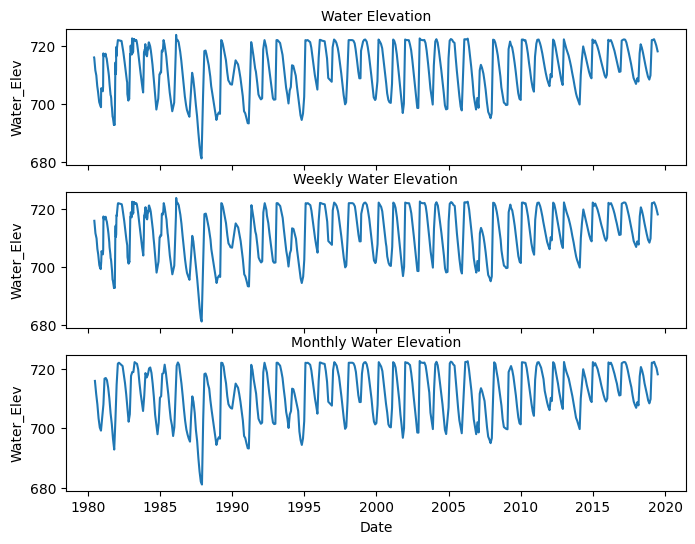

In [5]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(8,6))

sns.lineplot(x=dfs["Date"], y=dfs["Water_Elev"], ax=ax[0])
ax[0].set_title("Water Elevation", fontsize=10)

resampled_dfs = dfs[["Date", "Water_Elev"]].resample("W", on="Date").mean().reset_index()
sns.lineplot(x=resampled_dfs["Date"], y=resampled_dfs["Water_Elev"], ax=ax[1])
ax[1].set_title("Weekly Water Elevation", fontsize=10)

resampled_dfs = dfs[["Date", "Water_Elev"]].resample("M", on="Date").mean().reset_index()
sns.lineplot(x=resampled_dfs["Date"], y=resampled_dfs["Water_Elev"], ax=ax[2])
ax[2].set_title("Monthly Water Elevation", fontsize=10)

plt.show()

In [6]:
# Create a weekly water elevation dateset
dfs_wk = dfs[["Date", "Water_Elev"]].resample("W", on="Date").mean().reset_index(drop=False)

# Check time intervals
dfs_wk["delta"] = dfs_wk["Date"] - dfs_wk["Date"].shift(1)
dfs_wk[["Date", "Water_Elev", "delta"]]

,Date,Water_Elev,delta
0,1980-06-15,715.90,NaT
1,1980-06-22,NaN,7 days
2,1980-06-29,NaN,7 days
3,1980-07-06,NaN,7 days
4,1980-07-13,711.60,7 days
...,...,...,...
2033,2019-06-02,NaN,7 days
2034,2019-06-09,NaN,7 days
2035,2019-06-16,NaN,7 days
2036,2019-06-23,NaN,7 days


In [7]:
# Create a monthly water elevation dateset
dfs_mo = dfs[["Date", "Water_Elev"]].resample("M", on="Date").mean().reset_index(drop=False)

# Check time intervals
dfs_mo["delta"] = dfs_mo["Date"] - dfs_mo["Date"].shift(1)
dfs_mo[["Date", "Water_Elev", "delta"]].head(75)

,Date,Water_Elev,delta
0,1980-06-30,715.90,NaT
1,1980-07-31,711.60,31 days
2,1980-08-31,708.00,31 days
3,1980-09-30,703.35,30 days
4,1980-10-31,700.25,31 days
...,...,...,...
70,1986-04-30,721.30,30 days
71,1986-05-31,718.00,31 days
72,1986-06-30,714.90,30 days
73,1986-07-31,710.80,31 days


# Data Processing
Even though we downsized the data from weekly to monthly, there appears to be some months when there are no data. We can sum all the "NaN" values, resulting in 36 missing values in the entire monthly dataset. There are several ways to fill in the missing values. Here, we interpolate the missing values using the previous and next values.

In [8]:
# Now we can drop "delta" and find NaN within the monthly dataset
dfs_mo.drop('delta', axis=1, inplace=True)
dfs_mo.isna().sum()

Date           0
Water_Elev    38
dtype: int64

In [9]:
# There are 36 "NaN". Interpolate missing values and check if there are any missing values.
dfs_mo['Water_Elev'] = dfs_mo['Water_Elev'].interpolate()
dfs_mo.isna().sum()

Date          0
Water_Elev    0
dtype: int64

In [10]:
# Rearrange dataframe and re-date to "Month"
dfs_mo.set_index(
    pd.PeriodIndex(dfs_mo["Date"], freq="M"),
    inplace=True)
dfs_mo.drop("Date", axis=1, inplace=True)
dfs_mo.head()

,Water_Elev
Date,
1980-06,715.90
1980-07,711.60
1980-08,708.00
1980-09,703.35
1980-10,700.25


In [11]:
# Also reset index for new data after 2019/6/27
dfn.set_index(
    pd.PeriodIndex(dfn["Date"], freq="M"),
    inplace=True)
dfn.drop("Date", axis=1, inplace=True)
dfn.head()

,Water_Elev
Date,
2022-07,712.20
2022-08,712.27
2022-09,711.07
2022-11,709.64
2022-11,709.20


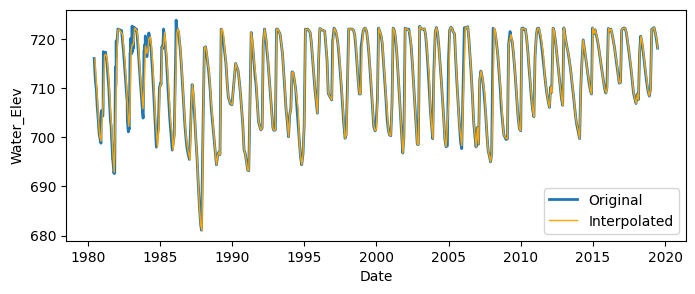

In [12]:
# Plot interpolated data in orange
sns.lineplot(x=dfs["Date"], y=dfs["Water_Elev"], label="Original", lw=2)
sns.lineplot(dfs_mo['Water_Elev'], color="orange", label="Interpolated", lw=1)
plt.show()

# Decomposition

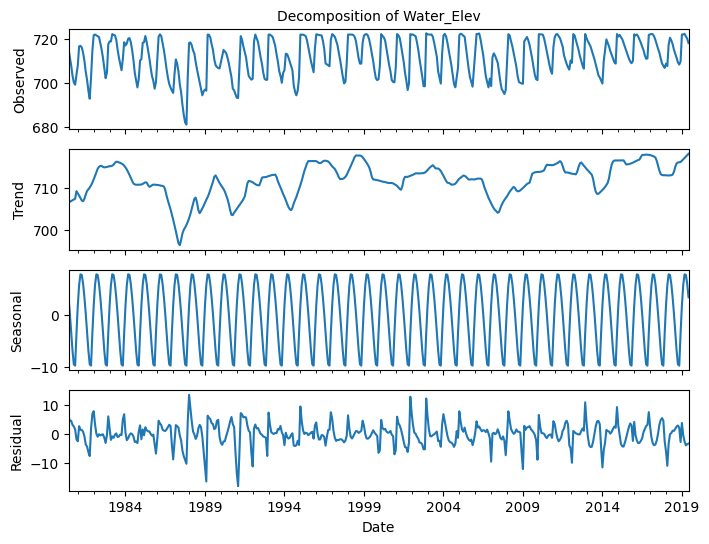

In [13]:
# Apply seasonal_decompose() from statsmodels.tsa.seasonal
decomposition = seasonal_decompose(dfs_mo['Water_Elev'], period=12, model="additive", extrapolate_trend="freq")

# Plot decomposed time series
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,6))
ax[0].set_title("Decomposition of Water_Elev", fontsize=10)

decomposition.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel("Observed")

decomposition.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel("Trend")

decomposition.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel("Seasonal")

decomposition.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel("Residual")

plt.show()

Decomposition of the time-series data tells us the trend, seasonal, and residual. It is similar to signal processing, which you decompose a wave into various fourier features. From above, we can conclude:
- The water trend appears to head up slightly over time. This indicates that the time-series is not stationary, but it is close to stationary.
- We clearly see seasonal fluctuations every year. This makes sense as we expect rainy season at the end of the year, while dry season at the mid-year.
- Finally, the residual or noise, can be as large as 10 to 20 feet of water level variation.

# Stationary
The ARIMA time-series model that we are interested in assumes that the underlying data is stationary. That means the data can fluctuates, but the general trend is more or less constant. By visually studying the plot above, we see that the water elevation fluctuates seasonally; however, the overall trend is roughly constant (imagine a horizontal line drawn across the plot). The Augmented Dickey-Fuller test and KPSS tests are two statistical tests to quatify stationary of a dataset:

- Null Hypothesis (H<sub>0</sub>): Time-series data is not stationary
- Alternate Hypothesis (H<sub>1</sub>): Time-series data is not stationary

If Pearson correlation's p-value returns a value of less than a significant value, which is typically 0.05, we can reject the null hypothesis and conclude that the data is not stationary. Another way is to compare the critical values populated from the `adfuller()` modules. If the 1%, 5%, and 10% critical values are greater than the ADF statistical result, we can conclude the dataset is stationary.

In [14]:
# Apply adfuller() from statsmodels.tsa.stattools
res_adf = adfuller(dfs_mo.values)
res_adf

(-4.304569626913569,
 0.00043618772699868834,
 15,
 453,
 {'1%': -3.444868194858831,
  '5%': -2.867941416548597,
  '10%': -2.5701797149735146},
 2523.863218884974)

In [15]:
print(f"p-value: {res_adf[1]:.5f} < 0.05 ")
print(f"ADF stat: {res_adf[0]:.3f} < 1%: {res_adf[4]['1%']:.3f}, 5%: {res_adf[4]['5%']:.3f} and 10%: {res_adf[4]['10%']:.3f}")

p-value: 0.00044 < 0.05 
ADF stat: -4.305 < 1%: -3.445, 5%: -2.868 and 10%: -2.570


In [16]:
# Apply kpss() from statsmodels.tsa.stattools
res_kpss = kpss(dfs_mo.values, regression="c", nlags="auto")
print(f"p-value: {res_kpss[1]:.5f} < 0.05 ")

p-value: 0.01000 < 0.05 


<ipython-input-16-ae0b2eddc110>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res_kpss = kpss(dfs_mo.values, regression="c", nlags="auto")


We see that p-value from both `adfuller()` and `kpss()` are less than 0.05 and the critical values are all greater than the ADT stat results. Therefore, we reject the null hypothesis and conclude that the data is stationary, although we learned an upward trend in the decomposition above.

# Selecting AR and MA terms
ACF and PACF charts can help us find appropriate values for parameters Auto Regressive (or `p`) and Moving Average (or `q`) terms for the ARIMA model.

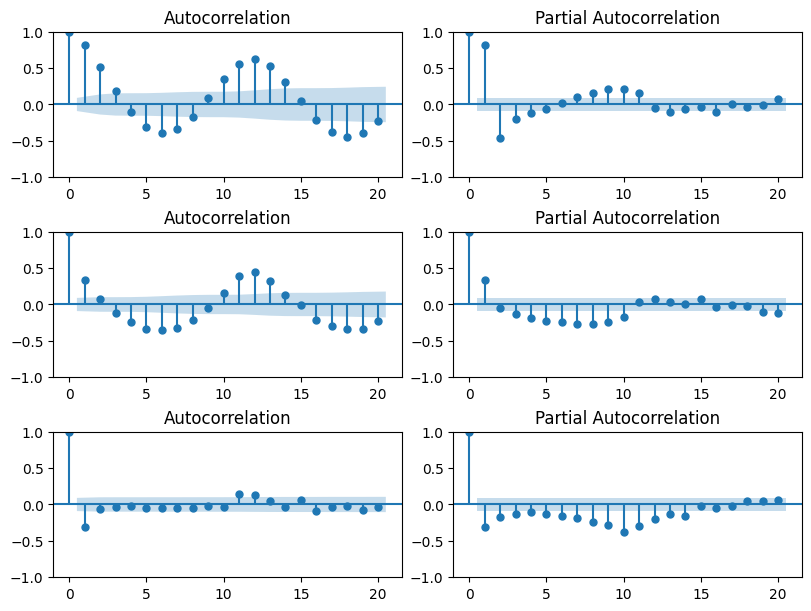

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), layout="constrained")

# Top row: Original
plot_acf(dfs_mo, lags=20, ax=ax[0, 0])
plot_pacf(dfs_mo, lags=20, ax=ax[0, 1])

# Second row: 1st Differencing
plot_acf(dfs_mo.diff().dropna(), lags=20, ax=ax[1, 0])
plot_pacf(dfs_mo.diff().dropna(), lags=20, ax=ax[1, 1])

# Last row: 2nd Differencing
plot_acf(dfs_mo.diff().diff().dropna(), lags=20, ax=ax[2, 0])
plot_pacf(dfs_mo.diff().diff().dropna(), lags=20, ax=ax[2, 1])

plt.show()

One thing to note is that both ACF and PACF charts for the original and the first order `diff()` series exhibit a harmonic motion, which hints the need for seasonal term in the ARIMA model -- a SARIMA model. Also note that since we are using the monthly dataset, the lags exhibit a seasonal pattern with a period of about 12 -- annual fluctuations as we observed in the decomposition.

Let's take a closer look at the ACF and PACF charts for the original data. In the ACF chart (upper), lags 1, 2, and 3 are significant. However, lag 3 is only a bit above the significant limit (blue zone). In the PACF chart (lower), there are also a few significant spikes.

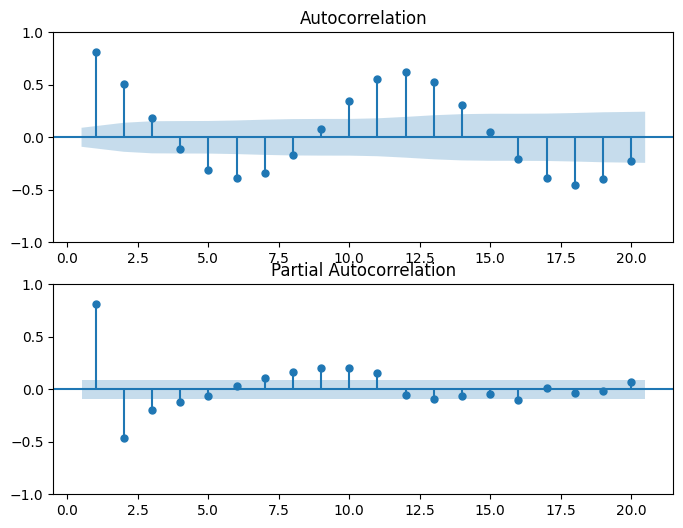

In [19]:
# Original observations
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6))

plot_acf(dfs_mo, lags=20, zero=False, ax=ax[0])
plot_pacf(dfs_mo, lags=20, zero=False, ax=ax[1])

plt.show()

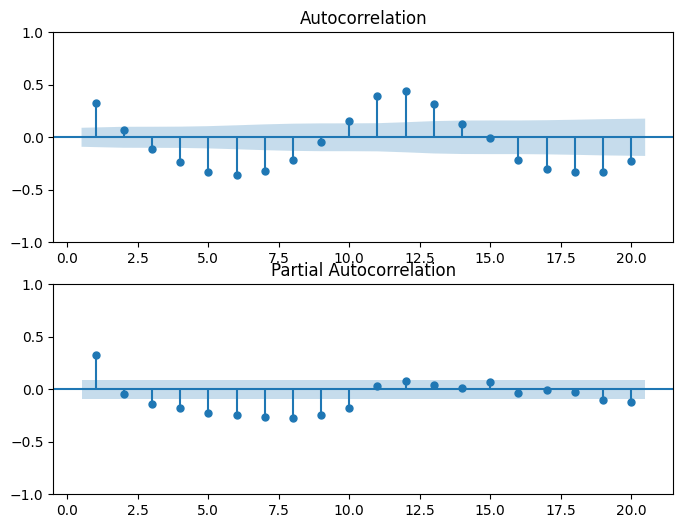

In [20]:
# First order differencing of original series
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6))

plot_acf(dfs_mo.diff().dropna(), lags=20, zero=False, ax=ax[0])
plot_pacf(dfs_mo.diff().dropna(), lags=20, zero=False, ax=ax[1])

plt.show()

The first order differencing actully weakens the correlation. For now, we continue to use the original series (no differencing
) and select `p=1` and `q=1` (known as "ARMA11") as a model to start with.  

In addition, since we noticed that a SARIMA model is needed, we need to determine the `seasonal_order=(P,D,Q,S)` components for the model. From above, we know that the period is 12 months (`S=12`). Therefore, instead of subtracting the last value, we subtract the time series value from the previous one cycle and apply ACF and PACF to evaluate the terms. The charts below indicate that differencing to 3rd order do not make any difference beyong that, but there is one significant spike: `P=1`.

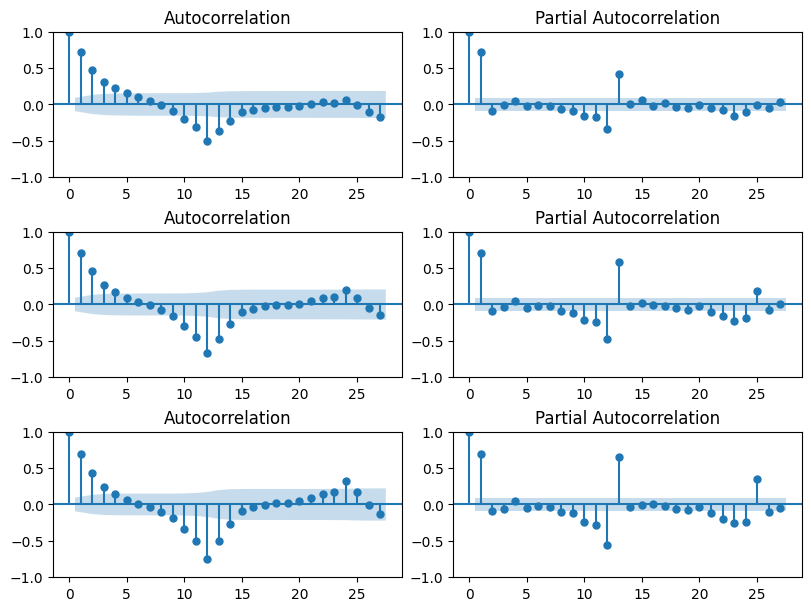

In [21]:
# Seasonal terms: P, D, Q, S
S = 12

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), layout="constrained")

# Top row: 1st Differencing
plot_acf(dfs_mo.diff(S).dropna(), ax=ax[0, 0])
plot_pacf(dfs_mo.diff(S).dropna(), ax=ax[0, 1])

# Middle row: 2nd Differencing
plot_acf(dfs_mo.diff(S).diff(S).dropna(), ax=ax[1, 0])
plot_pacf(dfs_mo.diff(S).diff(S).dropna(), ax=ax[1, 1])

# Last row: 3rd Differencing
plot_acf(dfs_mo.diff(S).diff(S).diff(S).dropna(), ax=ax[2, 0])
plot_pacf(dfs_mo.diff(S).diff(S).diff(S).dropna(), ax=ax[2, 1])

plt.show()

# Model Fitting


In [22]:
y = dfs_mo.squeeze()
X = dfs_mo.shift(1).fillna(0.0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [23]:
# Apply Seasonal ARIMA() model from statsmodels.tsa.arima.model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Make a list to store p, q, and results
order = []

# Loop over p and q terms from 0 to 3:
for p in range(4):
  for q in range(4):
    model = SARIMAX(y_train, order=(p,0,q), freq="M")
    res = model.fit()
    order.append((p, q, res.aic, res.bic))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: Us

In [24]:
# Let's sort for AIC. Smaller AIC is a better model.
order_df = pd.DataFrame(order, columns=["p", "q", "AIC", "BIC"])
order_df.sort_values(by=["AIC","BIC"], inplace=True)
order_df.head()

,p,q,AIC,BIC
13,3,1,2480.541345,2500.766372
8,2,0,2568.907649,2581.042665
12,3,0,2570.043997,2586.224018
9,2,1,2570.402546,2586.582568
7,1,3,2570.916585,2591.141612


Based on the `order_df.head()` result above, p=3 and q=1 yield the lowest AIC and BIC values. We plot both fitted and predicted data. The fitted data looks good, but the predicted part is a straight line --- that is because we knew that seasonal component is there, and we will have to use SARIMA model to make forecasting.

In [37]:
# Apply Seasonal ARIMA() model from statsmodels.tsa.arima.model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit model
sarima_01_model = SARIMAX(y_train, order=(3,0,1), freq='M')
model_fit = sarima_01_model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Water_Elev   No. Observations:                  422
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -1235.271
Date:                Thu, 18 Jul 2024   AIC                           2480.541
Time:                        05:25:28   BIC                           2500.766
Sample:                    06-30-1980   HQIC                          2488.534
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1966      0.038     57.161      0.000       2.121       2.272
ar.L2         -1.6762      0.060    -28.096      0.000      -1.793      -1.559
ar.L3          0.4797      0.021     22.590      0.0

(650.0, 750.0)

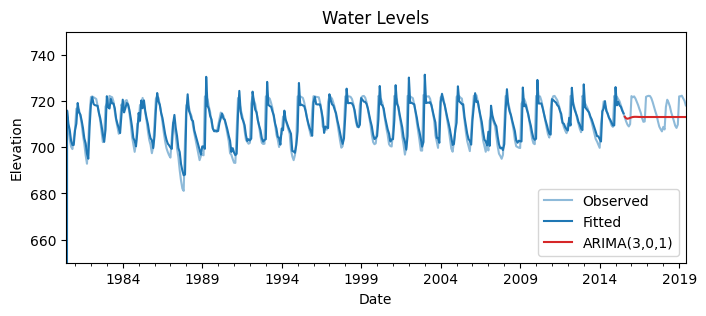

In [39]:
# Forecast with ARIMA
y_pred = model_fit.predict(alpha=0.05)  # 95% conf
y_fore = model_fit.forecast(len(X_test))

# Plot modeled data
ax = y.plot(alpha=0.5, title="Water Levels", ylabel="Elevation", label="Observed")
ax = y_pred.plot(ax=ax, label="Fitted", color='C0')
ax = y_fore.plot(ax=ax, label="ARIMA(3,0,1)", color='C3')
ax.legend();
ax.set_ylim([650, 750])

# Auto ARIMA Model
Now, let's try the automated ARIMA model. From above, we already saw that differencing shouldn't be greater than third order for both `d` and `D` terms. So, we can safely set a limit to reduce runtime. Both ACF and PACF charts also showed that the significant spikes quickly reduced to `p,q=max(3)` and `Q,P=max(5)`.

In [40]:
# Create auto_arima model
model_auto = pm.auto_arima(y_train, #time series
                      seasonal=True, # is the time series seasonal
                      m=12, # the seasonal period
                      d=None, # non-seasonal difference order
                      D=None, # seasonal difference order
                 	    max_p=3, # max value of p to test
                      max_q=3, # max value of p to test
                      max_P=5, # max value of P to test
                      max_Q=5, # max value of Q to test
                      information_criterion='aic', # used to select best mode
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True)

# Print model summary
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2457.614, Time=12.00 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3024.314, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2471.586, Time=2.64 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2629.062, Time=1.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6742.354, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=2455.868, Time=5.30 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=2452.370, Time=2.60 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=2447.690, Time=8.14 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=2456.760, Time=12.94 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=2449.231, Time=8.06 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=2436.460, Time=1.16 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=2487.601, Time=0.45 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=2398.004, Time=8.89 sec
 ARIMA(1,0,2)(3,0,0)[12] intercept   : AIC=2399.816, Time=17.03 sec
 ARIMA(1,0,2)(2,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(650.0, 750.0)

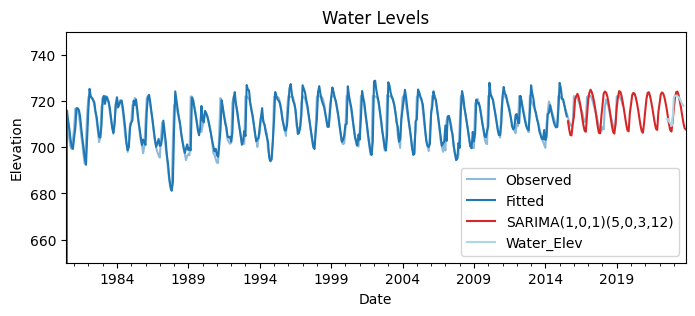

In [42]:
# Fit model
# sarima_02_model = SARIMAX(y_train, order=(1,0,1), seasonal_order=(2,0,1,12))
sarima_02_model = SARIMAX(y_train, order=(1,0,1), seasonal_order=(5,0,3,12))
model_fit = sarima_02_model.fit()

# Forecast with ARIMA
y_pred = model_fit.predict(alpha=0.05)  # 95% conf
y_fore = model_fit.forecast(100)

# Plot modeled data
ax = y.plot(alpha=0.5, title="Water Levels", ylabel="Elevation", label="Observed")
ax = y_pred.plot(ax=ax, label="Fitted", color='C0')
ax = y_fore.plot(ax=ax, label="SARIMA(1,0,1)(5,0,3,12)", color='C3')
ax = dfn.plot(ax=ax, color="lightblue") # Include new data
ax.legend();
ax.set_ylim([650, 750])